In [38]:
# Essential imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

import numpy as np

import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [39]:
# Load data
data = pd.read_csv("superstore_final_dataset.csv")

In [40]:
# Feature Engineering: 

# 1. Convert dates, create new features
data[['Order_Year', 'Order_Month', 'Order_Day']] = data['Order_Date'].str.split("-", expand=True).astype(int)

# 2. Adding features for various category types
categoryType = pd.get_dummies(data["Category"], prefix='Category')
# Combine the encoded columns with the original DataFrame
data = pd.concat([data, categoryType], axis=1)
# Drop the original 'categoryType' column if no longer needed
data.drop(columns=["Category"], inplace=True)

# 3. Adding features for various region types
regionType = pd.get_dummies(data['Region'], prefix='Region')
# Combine the encoded columns with the original DataFrame
data = pd.concat([data, regionType], axis=1)
# Drop the original 'regionType' column if no longer needed
data.drop(columns=['Region'], inplace=True)

# 4. Adding features for various segment types
segType = pd.get_dummies(data['Segment'], prefix='Segment')
# Combine the encoded columns with the original DataFrame
data = pd.concat([data, segType], axis=1)
# Drop the original 'segType' column if no longer needed
data.drop(columns=['Segment'], inplace=True)

# 5. Adding features for various ship mode types
regionType = pd.get_dummies(data['Ship_Mode'], prefix='Ship_Mode')
# Combine the encoded columns with the original DataFrame
data = pd.concat([data, regionType], axis=1)
# Drop the original 'regionType' column if no longer needed
data.drop(columns=['Ship_Mode'], inplace=True)

# List of columns created 
columns_of_interest = ['Category_Furniture','Category_Office Supplies',
                       'Category_Technology','Region_Central','Region_East',
                       'Region_South','Region_West', 'Discount', 'Quantity', 
                       'Order_Month', 'Order_Year', 'Segment_Consumer','Segment_Corporate',
                       'Segment_Home Office', 'Ship_Mode_First Class','Ship_Mode_Same Day',
                       'Ship_Mode_Second Class','Ship_Mode_Standard Class', 'Order_Year','Order_Month','Order_Day']

# Ensuring one-hot encoding value is of type int not bool
for column in columns_of_interest:
    data[column] = data[column].replace({True: 1, False: 0})

data.head()


/var/folders/1v/rphybfn151d42hnnhv4s72jm0000gn/T/ipykernel_94008/1072522321.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[column] = data[column].replace({True: 1, False: 0})


,Row ID,Order_ID,Order_Date,Ship_Date,Customer_ID,Customer_Name,Country,City,State,Postal_Code,...,Region_East,Region_South,Region_West,Segment_Consumer,Segment_Corporate,Segment_Home Office,Ship_Mode_First Class,Ship_Mode_Same Day,Ship_Mode_Second Class,Ship_Mode_Standard Class
0,1,CA-2013-152156,2013-11-09,2013-11-12,CG-12520,Claire Gute,United States,Henderson,Kentucky,42420,...,0,1,0,1,0,0,0,0,1,0
1,2,CA-2013-152156,2013-11-09,2013-11-12,CG-12520,Claire Gute,United States,Henderson,Kentucky,42420,...,0,1,0,1,0,0,0,0,1,0
2,3,CA-2013-138688,2013-06-13,2013-06-17,DV-13045,Darrin Van Huff,United States,Los Angeles,California,90036,...,0,0,1,0,1,0,0,0,1,0
3,4,US-2012-108966,2012-10-11,2012-10-18,SO-20335,Sean O'Donnell,United States,Fort Lauderdale,Florida,33311,...,0,1,0,1,0,0,0,0,0,1
4,5,US-2012-108966,2012-10-11,2012-10-18,SO-20335,Sean O'Donnell,United States,Fort Lauderdale,Florida,33311,...,0,1,0,1,0,0,0,0,0,1


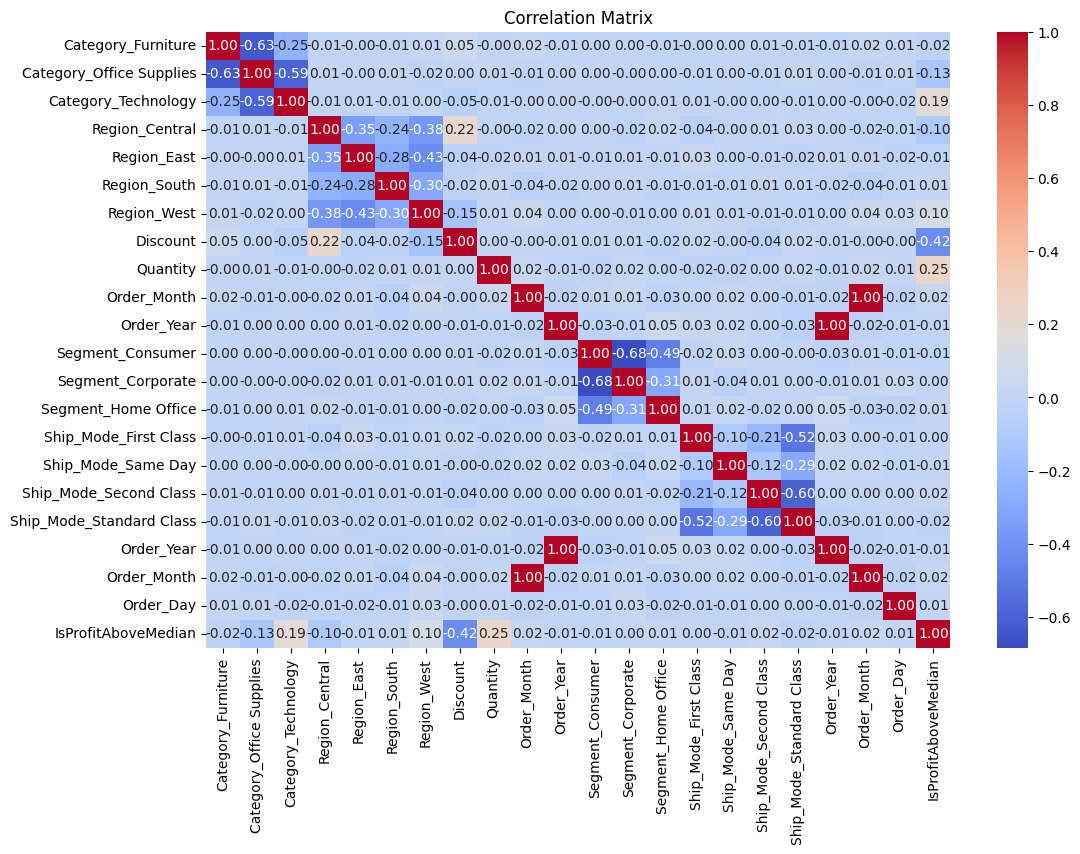

In [41]:
# Creating a binary output column 'IsProfitAboveMedian' based on the median of 'Profit'
threshold = data['Profit'].median()  # Calculate the median of the 'Profit' column
data['IsProfitAboveMedian'] = (data['Profit'] > threshold).astype(int)  # 1 if 'Profit' > median, else 0

# Separating numerical and categorical columns from columns_of_interest
df_of_interest = data[columns_of_interest + ['IsProfitAboveMedian']]

numerical_features = df_of_interest.select_dtypes(include=['float64', 'int64'])  # Numerical columns
categorical_features = df_of_interest.select_dtypes(include=['object', 'category'])  # Categorical columns

# Correlation Matrix for Numerical Features
if not numerical_features.empty:  # Ensure there are numerical features to plot
    correlation_matrix = numerical_features.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()


In [42]:
# Updating feature columns based on correlation matrix
columns_of_interest = ['Category_Office Supplies', 'Category_Technology', 'Region_West', 'Region_Central',
       'Discount', 'Quantity']

X = data[columns_of_interest]
y = data['IsProfitAboveMedian']

Feature columns based on correlation matrix:
    ['Category_Office Supplies', 'Category_Technology', 'Region_West', 'Region_Central',
    'Discount', 'Quantity']

In [43]:
# Feature Selection using SelectKBest

# Select top  features using Chi-Square test
selector = SelectKBest(score_func=mutual_info_regression, k=5)
selector.fit(X, y)

# Display selected features
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)


Selected features: Index(['Category_Office Supplies', 'Region_West', 'Region_Central', 'Discount',
       'Quantity'],
      dtype='object')


In [44]:
columns_of_interest = ['Category_Office Supplies', 'Category_Technology', 'Region_West',
       'Discount', 'Quantity']

X = data[columns_of_interest]
y = data['IsProfitAboveMedian']

In [45]:
# Populating Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
# Initialize a logistic regression model
classifier = LogisticRegression()

# Train the logistic regression model
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7430340557275542
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       985
           1       0.72      0.77      0.75       953

    accuracy                           0.74      1938
   macro avg       0.74      0.74      0.74      1938
weighted avg       0.74      0.74      0.74      1938



In [47]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7554179566563467
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       985
           1       0.74      0.78      0.76       953

    accuracy                           0.76      1938
   macro avg       0.76      0.76      0.76      1938
weighted avg       0.76      0.76      0.76      1938



In [48]:
# Doing SVC 
svm_model = SVC(kernel='rbf', random_state=42, max_iter=10000)  # Radial basis function kernel is commonly used for non-linear classification
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7543859649122807
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       985
           1       0.74      0.78      0.76       953

    accuracy                           0.75      1938
   macro avg       0.76      0.75      0.75      1938
weighted avg       0.76      0.75      0.75      1938



In [49]:
def build_model(num_layers, neurons, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1]))
    for _ in range(num_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Hyperparameter tuning
num_layers = 9
neurons = 128
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 72

# Build and train the model
model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.1,          # Reduce learning rate by this factor
    patience=3,          # Wait 3 epochs before reducing
    min_lr=1e-5          # Minimum learning rate
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=batch_size, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test,verbose=0)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")




Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5621 - loss: 0.6660 - val_accuracy: 0.7310 - val_loss: 0.5367 - learning_rate: 0.0010
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.5285 - val_accuracy: 0.7245 - val_loss: 0.5370 - learning_rate: 0.0010
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7373 - loss: 0.5178 - val_accuracy: 0.7200 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7380 - loss: 0.5120 - val_accuracy: 0.7310 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7334 - loss: 0.5166 - val_accuracy: 0.7065 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7415 - loss: 0.5134 - val_accuracy: 0.7297 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7465 - loss: 0.5058 - val_accuracy: 0.7252 - va

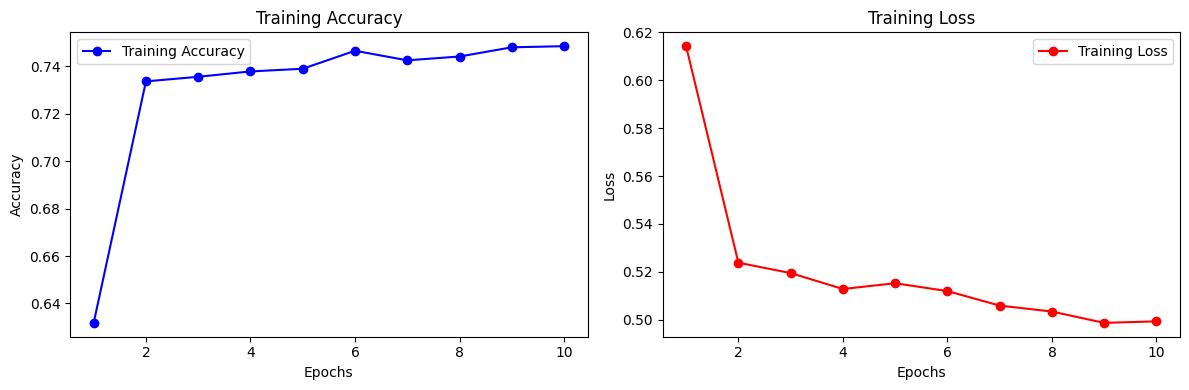

In [50]:
# Extract accuracy and loss values
accuracy_values = history.history['accuracy']
loss_values = history.history['loss']

def plot_training_history(accuracy_values, loss_values):
    """Plots the training accuracy and loss curves."""

    epochs = range(1, len(accuracy_values) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy_values, 'bo-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_values, 'ro-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(accuracy_values, loss_values)

In [51]:
# Using Product Name as an input
X = data['Product Name']
y = data['IsProfitAboveMedian']

# Vectorize the text using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vectorized = vectorizer.fit_transform(X)


In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


In [54]:

# Doing Logistical Regression
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy: 0.7260061919504643
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72       985
           1       0.71      0.75      0.73       953

    accuracy                           0.73      1938
   macro avg       0.73      0.73      0.73      1938
weighted avg       0.73      0.73      0.73      1938



In [55]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7069143446852425
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       985
           1       0.70      0.71      0.70       953

    accuracy                           0.71      1938
   macro avg       0.71      0.71      0.71      1938
weighted avg       0.71      0.71      0.71      1938



In [56]:
# Doing SVC 
svm_model = SVC(kernel='rbf', random_state=42, max_iter=10000)  # Radial basis function kernel is commonly used for non-linear classification
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7198142414860681
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       985
           1       0.70      0.74      0.72       953

    accuracy                           0.72      1938
   macro avg       0.72      0.72      0.72      1938
weighted avg       0.72      0.72      0.72      1938



In [57]:
def build_model(num_layers, neurons, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1]))
    for _ in range(num_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Hyperparameter tuning
num_layers = 9
neurons = 128
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 72

# Build and train the model
model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.1,          # Reduce learning rate by this factor
    patience=3,          # Wait 3 epochs before reducing
    min_lr=1e-5          # Minimum learning rate
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=batch_size, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test,verbose=0)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5234 - loss: 0.6917 - val_accuracy: 0.6948 - val_loss: 0.6291 - learning_rate: 0.0010
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7288 - loss: 0.5810 - val_accuracy: 0.7290 - val_loss: 0.5527 - learning_rate: 0.0010
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7716 - loss: 0.4876 - val_accuracy: 0.7277 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7842 - loss: 0.4531 - val_accuracy: 0.7142 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7912 - loss: 0.4366 - val_accuracy: 0.7155 - val_loss: 0.5858 - learning_rate: 0.0010
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7938 - loss: 0.4178 - val_accuracy: 0.6981 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7889 - loss: 0.4140 - val_accuracy: 0.7174 - va

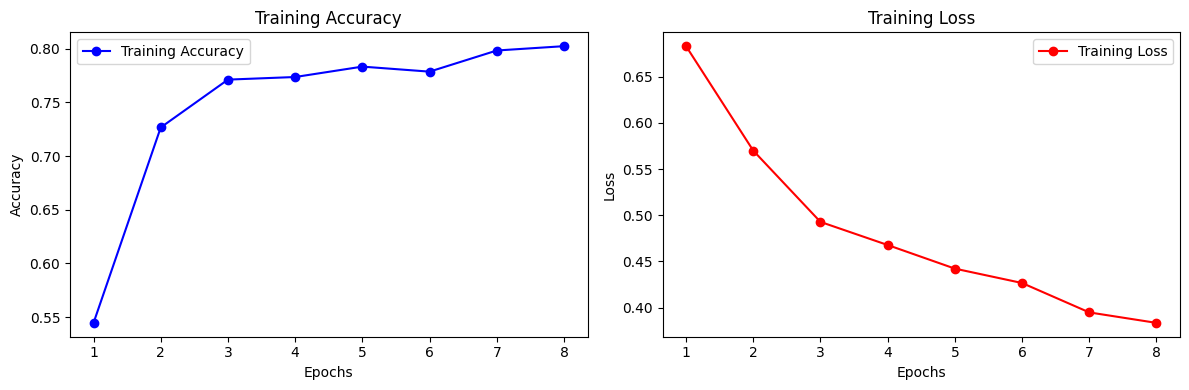

In [58]:
# Extract accuracy and loss values
accuracy_values = history.history['accuracy']
loss_values = history.history['loss']

def plot_training_history(accuracy_values, loss_values):
    """Plots the training accuracy and loss curves."""

    epochs = range(1, len(accuracy_values) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy_values, 'bo-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_values, 'ro-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(accuracy_values, loss_values)